## **PRACTICAL SESSION 1** — Deep Learning for predictive maintenance

The dataset used is the **AI4I 2020** Predictive Maintenance Dataset, which contains 10,000 instances of industrial sensor data. Each instance represents the operating condition of a machine and is associated with a label indicating whether a failure has occurred and, if so, what type of failure it is.

The 5 possible labels are:



*   **TWF**: Tool Wear Failure
*   **HDF**: Heat Dissipation Failure
*   **PWF**: Power Failure
*   **OSF**: Overstrain Failure
*   **RNF**: Random Failure


The data is available on eCAMPUS as CSV file called: "ai4i2020.csv"



## **PRACTICAL SESSION Goal** — Ceate a deep leanring model allowing to realize a predictive maintenance mission

## **1 - Analysis of the dataset**



All libraries used ***SHOULD BE PLACED*** in the code cell below

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

**QUESTION:** Load dataset and display some lines of the csv file.

In [15]:
# Load the dataset
file_path = "ai4i2020.csv"  # Make sure the file is in the same directory or provide the full path
df = pd.read_csv(file_path)

# Display the first few rows
print(df.head())

   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    0  
1    0    0    0    0  
2    0  

**QUESTION:** Display the distribution of machine failures and non-failures with a bar graph.

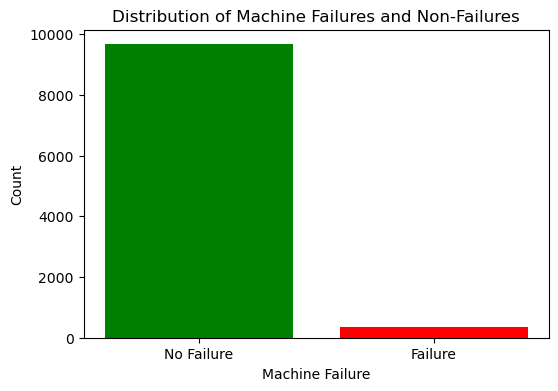

In [21]:
failure_counts = df['Machine failure'].value_counts()

# Plot the distribution
plt.figure(figsize=(6, 4))
plt.bar(failure_counts.index, failure_counts.values, color = ['green','red'], tick_label=['No Failure', 'Failure'])
plt.xlabel('Machine Failure')
plt.ylabel('Count')
plt.title('Distribution of Machine Failures and Non-Failures')
plt.show()

**ANALYSIS QUESTION:** What do you observe?

Il y a beaucoup plus de mahcine sans failure que de machine avec failure

**ANALYSIS QUESTION:** What will be the consequence of this phenomenon on the model's learning?

Problème de quantité pour entrainer un modèle

**QUESTION:** Create a bar chart showing the distribution of different failure types (TWF, HDF, PWF, OSF, RNF). Display the exact values above each bar in the chart."

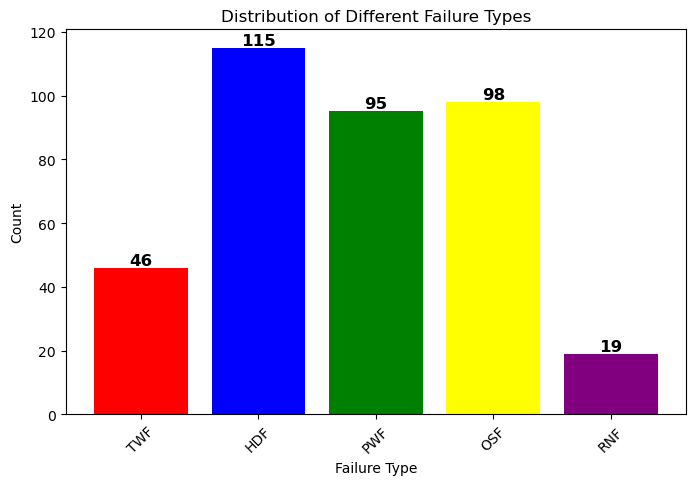

In [27]:
# Failure types to analyze
failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']

# Count occurrences of each failure type
failure_counts = df[failure_types].sum()

# Create the bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(failure_counts.index, failure_counts.values, color=['red','blue','green','yellow','purple'])

# Add exact values above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Labels and title
plt.xlabel('Failure Type')
plt.ylabel('Count')
plt.title('Distribution of Different Failure Types')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.show()

**ANALYSIS QUESTION:** What do you observe?

Bonne quantité pour HDF PWF OSF mais manque pour TWF RNF

**QUESTION:** Create a bar chart showing the distribution of failure types (TWF, HDF, PWF, OSF, RNF) among machines that experienced a failure (Machine failure == 1). Additionally, add a "No Specific Failure" category to count cases where a machine failed but no specific failure type was recorded. Display the exact values above each bar in the chart."

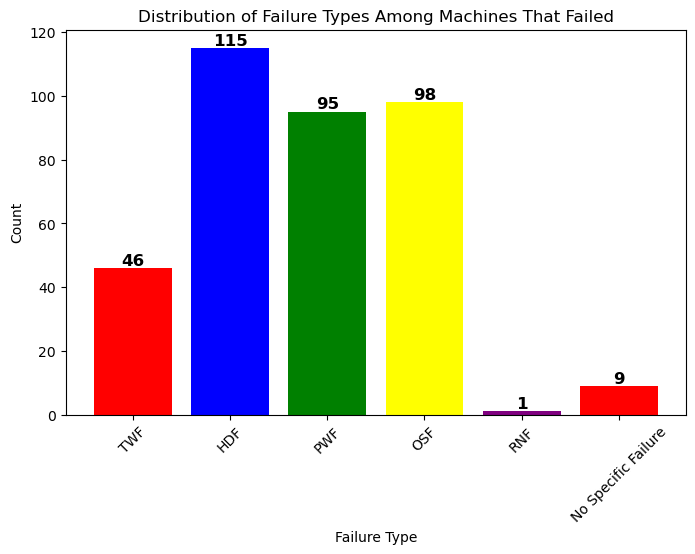

In [31]:
# Failure types to analyze
failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']

# Filter machines that experienced failure
failed_machines = df[df['Machine failure'] == 1]

# Count occurrences of each failure type
failure_counts = failed_machines[failure_types].sum()

# Count machines that failed but had no specific failure type
no_specific_failure_count = (failed_machines[failure_types].sum(axis=1) == 0).sum()

# Add "No Specific Failure" category
failure_counts['No Specific Failure'] = no_specific_failure_count

# Create the bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(failure_counts.index, failure_counts.values, color=['red','blue','green','yellow','purple'])

# Add exact values above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Labels and title
plt.xlabel('Failure Type')
plt.ylabel('Count')
plt.title('Distribution of Failure Types Among Machines That Failed')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.show()

**ANALYSIS QUESTION:** What do you obsrve comapred to the previous question ? What can you conclude?

"Write your response here"

**QUESTION:** Display the names of the different columns in the dataset with their respective data types.

In [35]:
# Display column names with data types
print(df.dtypes)

UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object


**ANALYSIS QUESTION:** To train the model, what will be the inputs and outputs (What are the names of the columns that you will use?)? Justify your response.
Remember, you want to predict if the machine will fail, and if so, what kind of failure. You need to yse previous results to jsurtify your response.

inputs: caracteristiques machines / données pannes précédentes / conditions env
outputs: failure / type

## **2- Train model Without balancing the dataset**

---



In this section, you must build and train a model without rebalancing the dataset.

**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [71]:
# Define features (X) and target variable (Y)
X = df.drop(columns=['Product ID','Type','Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']).values # All columns except 'Machine failure'
Y = df['Machine failure'].values # Target column

# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Display the number of elements in each set
print(f'X_train: {X_train.shape[0]} rows, {X_train.shape[1]} columns')
print(f'Y_train: {Y_train.shape[0]} elements')
print(f'X_test: {X_test.shape[0]} rows, {X_test.shape[1]} columns')
print(f'Y_test: {Y_test.shape[0]} elements')

X_train: 8000 rows, 6 columns
Y_train: 8000 elements
X_test: 2000 rows, 6 columns
Y_test: 2000 elements


**QUESTION** Code below the model architecture

In [73]:
# Standardize the data (important for neural networks)
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

# Build the Neural Network model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),  # Input Layer
    keras.layers.Dense(32, activation='relu'),  # Hidden Layer 1
    keras.layers.Dense(1, activation='sigmoid')  # Output Layer (binary classification)
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model architecture
model.summary()


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,561 (10.00 KB)

 Trainable params: 2,561 (10.00 KB)

 Non-trainable params: 0 (0.00 B)

**QUESTION** Code below the algorithms allowing to train model

**WARNING!** You need to plot the training and test accuracy and loss to check if our model is overfitting

Epoch 1/71
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - accuracy: 0.9749 - loss: 0.0763 - val_accuracy: 0.9755 - val_loss: 0.0761
Epoch 2/71
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - accuracy: 0.9692 - loss: 0.0803 - val_accuracy: 0.9725 - val_loss: 0.0815
Epoch 3/71
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - accuracy: 0.9708 - loss: 0.0824 - val_accuracy: 0.9735 - val_loss: 0.0784
Epoch 4/71
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - accuracy: 0.9693 - loss: 0.0858 - val_accuracy: 0.9730 - val_loss: 0.0779
Epoch 5/71
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - accuracy: 0.9727 - loss: 0.0728 - val_accuracy: 0.9710 - val_loss: 0.0771
Epoch 6/71
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.9757 - loss: 0.0695 - val_accuracy: 0.9745 - val_loss: 0.0807
Epoch 7/71
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - accuracy: 0.9716 - loss: 0.0835 - val_accuracy: 0.9740 - val_loss: 0.0749
Epoch 8/71
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - accuracy: 0.9733 - loss: 0.0737 - 

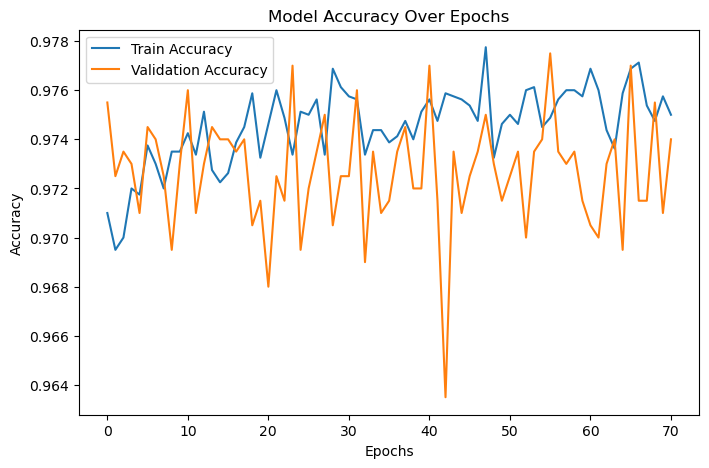

In [85]:
# Train the model
history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_test, Y_test))

# Evaluate model on test data
Y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Print accuracy and classification report
accuracy = accuracy_score(Y_test, Y_pred)
print(f"Test Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(Y_test, Y_pred))

plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy Over Epochs')
plt.show()

**QUESTION** Plot the confusion matrix and the classification report

**Tips:**

*   classification report link

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

*   Matrix confusion

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html





63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step


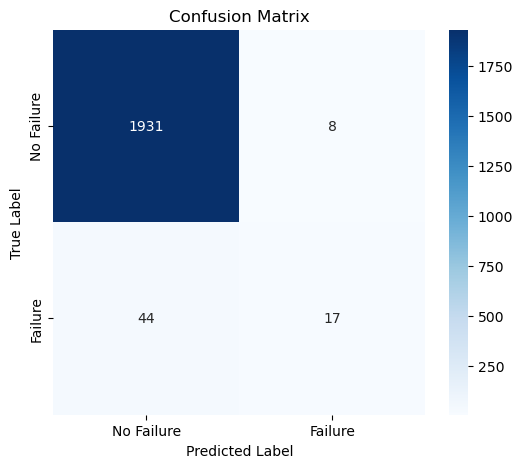

Test Accuracy: 0.9740

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1939
           1       0.68      0.28      0.40        61

    accuracy                           0.97      2000
   macro avg       0.83      0.64      0.69      2000
weighted avg       0.97      0.97      0.97      2000



In [93]:
# Predict on test set
Y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Compute Confusion Matrix
cm = confusion_matrix(Y_test, Y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['No Failure', 'Failure'], yticklabels=['No Failure', 'Failure'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print Classification Report
accuracy = accuracy_score(Y_test, Y_pred)
print(f"Test Accuracy: {accuracy:.4f}\n")
print("Classification Report:\n", classification_report(Y_test, Y_pred))

**ANALYSIS QUESTION** What do you observe? What can you conclude?

"Write your response here"

## **3- Train model With balancing the dataset**

---

 Methods for rebalancing a dataset:


*   Use oversampling techniques (e.g., SMOTE) to generate synthetic data for minority classes


> https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html



*   Apply undersampling techniques (e.g., random undersampling, Tomek Links, Edited Nearest Neighbors) to reduce the majority class size



> https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html



*   Use class weighting during model training to penalize errors on minority classes



> https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=fr


**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

**ANALYSIS QUESTION:** Explain the choices you made to balance the dataset.

"Write your response here"

**QUESTION:** Code below the model architecture


**TIP:** It could be interesting to keep it the same as before

**QUESTION** Code below the algorithms allowing to train model


**QUESTION** Plot the confusion matrix and the classification report

**ANALYSIS QUESTION** What do you observe? What can you conclude?

"Write your response here"